In [2]:
assert 1 == 1

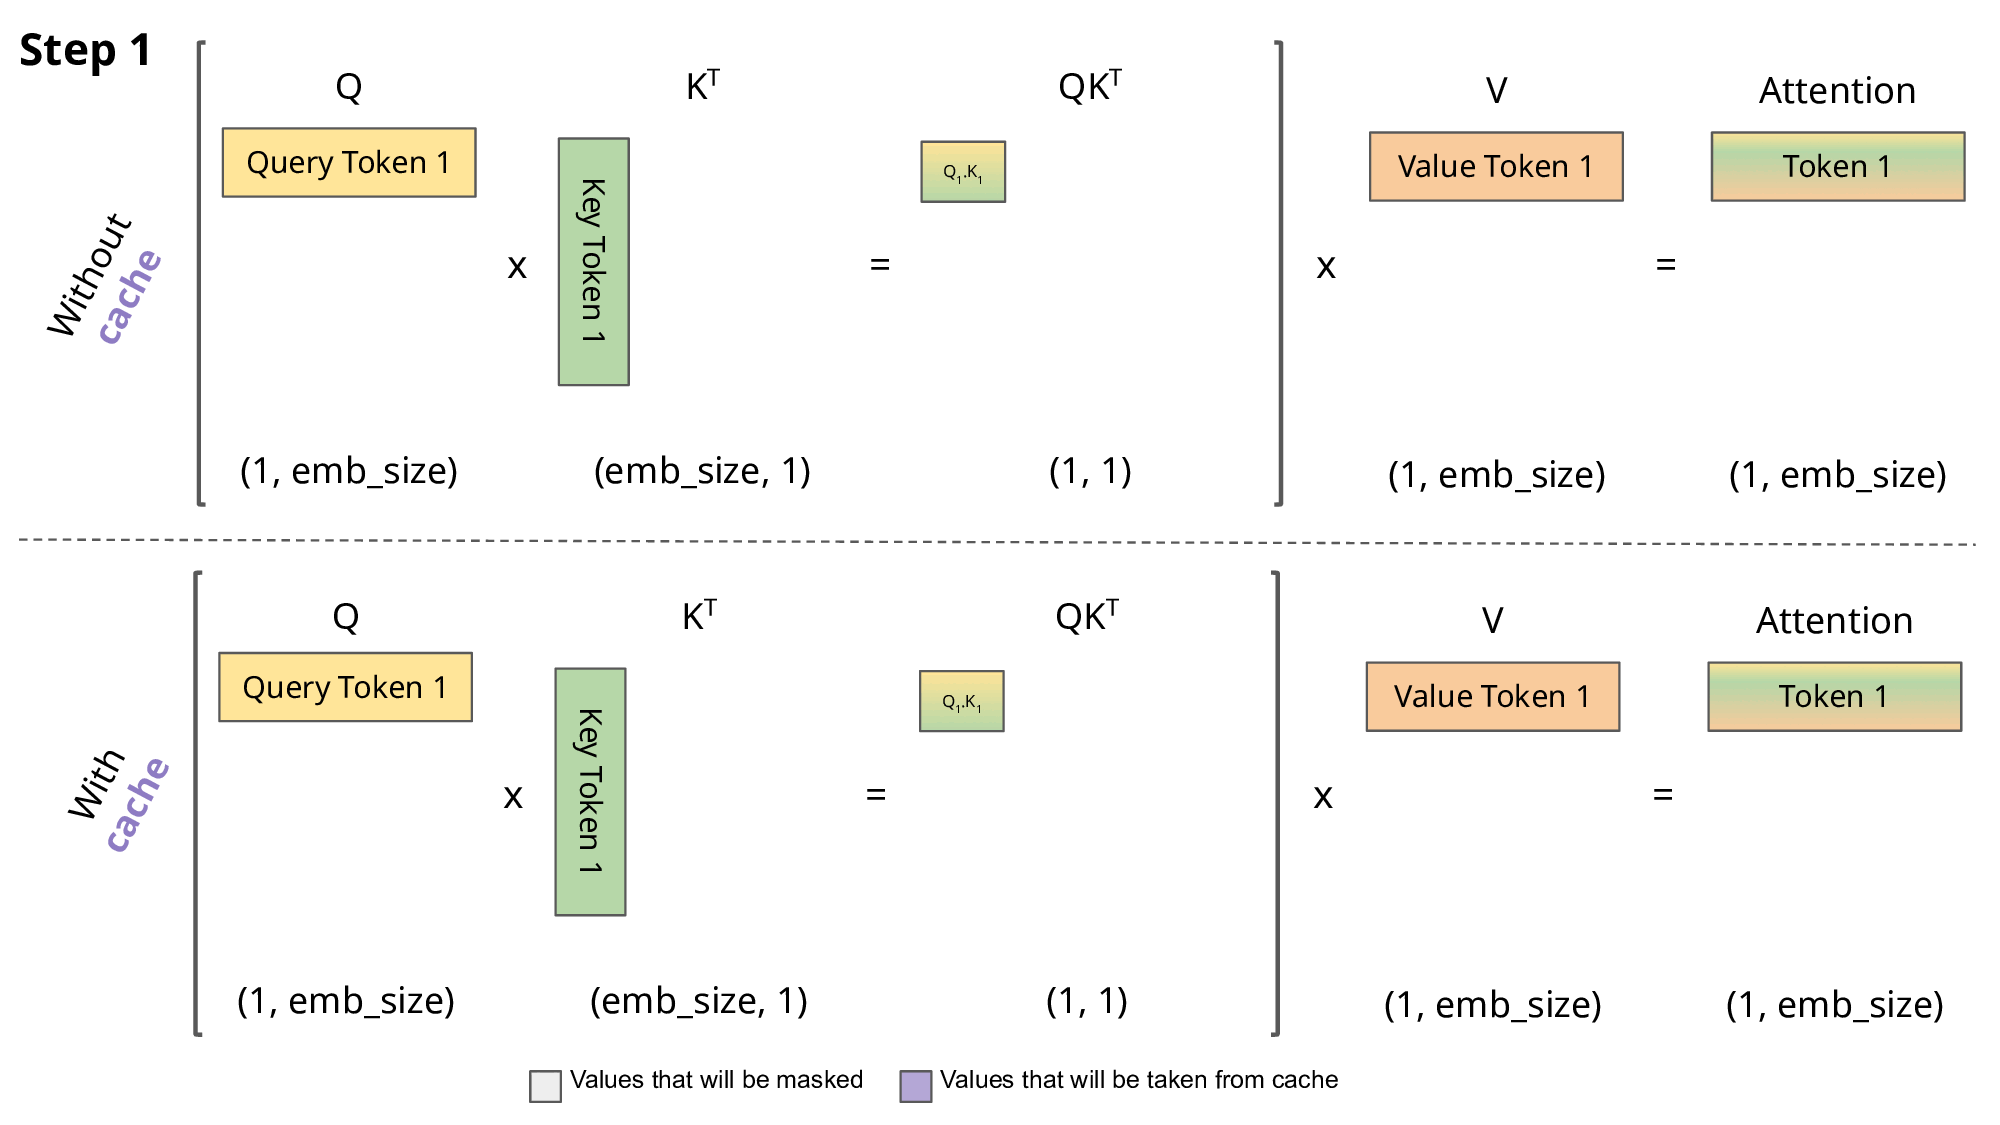

In [ ]:
import torch
import torch.nn as nn
from typing import Optional, Tuple, List
from torch.nn import CrossEntropyLoss
import math
from modeling_siglip import SiglipVisionConfig, SiglipVisionModel

class KVCache():
    def __init__(self):
        self.key_cache = []
        self.value_cache = []

    def num_items(self):
        if len(self.key_cache) == 0 :
            return 0
        else:
            ## the shape of kv_cache is [batch_size, num_heads_kv, seq_len, head_dim]

            return self.key_cache[0].size[-2]
        
    def update(self, key_states, value_states, layer_idx):

        if len(self.key_cache) <= layer_idx:
            self.key_cache.append(key_states)
            self.value_cache.append(value_states)
        else:

            self.key_cache[layer_idx] = torch.cat([self.key_cache[layer_idx], key_states], dim=-2)

            self.value_cache[layer_idx] = torch.cat([self.value_cache[layer_idx], value_states], dim=-2)

        return self.key_cache[layer_idx], self.value_cache[layer_idx]

def repeat_kv(hidden_states, n_rep):
    batch_size, num_key_value_heads, slen, head_dim = hidden_states.shape

    if n_rep == 1:
        return hidden_states
    
    hidden_states = hidden_states[:, :, None, :, :].expand(batch_size, num_key_value_heads, n_rep, slen, head_dim)

    return hidden_states.reshape(batch_size, num_key_value_heads*n_rep, slen, head_dim)


class GemmaConfig():
    def __init__(self, vocab_size, hidden_size, intermediate_size, num_hidden_layers, num_attention_heads, num_key_value_heads, head_dim = 256, max_position_embeddings = 8192, rms_norm_eps = 1e-6, rope_theta = 10000, attention_bias = False, attention_dropout = 0.0, pad_token_id = None, **kwargs):
        super().__init__()
        self.vocab_size = vocab_size
        self.max_position_embeddings = max_position_embeddings
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.num_key_value_heads = num_key_value_heads
        self.head_dim = head_dim
        self.rms_norm_eps = rms_norm_eps
        self.rope_theta = rope_theta
        self.attention_bias = attention_bias
        self.attention_dropout = attention_dropout
        self.pad_token_id = pad_token_id  



class PaliGemmaConfig():
    def __init__(self, vision_config= None, text_config = None, ignore_index = -100, image_token_index = 256000, vocab_size = 257152, projection_dim = 2048, hidden_size = 2048, pad_token_id = None, **kwargs):
        super().__init__()
        self.ignore_index = ignore_index
        self.image_token_index = image_token_index
        self.vocab_size = vocab_size
        self.projection_dim =projection_dim
        self.hidden_size = hidden_size
        self.vision_config = vision_config
        self.is_encoder_decoder = False
        self.pad_token_id = pad_token_id

        self.vision_config = SiglipVisionConfig(**vision_config)
        self.text_config = text_config

        self.text_config = GemmaConfig(**text_config, pad_token_id = pad_token_id)

        self.vocab_size = self.text_config.vocab_size

        self.text_config.num_image_tokens = (self.vision_config.image_size // self.vision_config.patch_size) **2

        self.vision_config.projection_dim = projection_dim


class GemmaRMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.dim = dim 
        self.eps = eps
        self.weight = nn.Parameter(torch.zeros(dim))

    def _norm(self, x):
        return x*torch.rsqrt(x.pow(2).mean(-1,keepdim=True) + self.eps )

    def forward(self, x):
        output = self._norm(x.float()) 
        output = output * (1.0 + self.weight.float())

        return output.type_as(x)

class GemmaMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.intermediate_size = config.intermediate_size
        self.gate_proj = nn.Linear(config.hidden_size, self.intermediate_size, bias=False)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=False)

        def forward(self, x):

            return self.down_proj(nn.functional.gelu(self.gate_proj(x), approximate="tanh") * self.up_proj(x))

class GemmaRotaryEmbeddings(nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base = 10000, device=None):
        super().__init__()
        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        self.device = device

        inv_freq = 1.0 / (self.base **(torch.arange(0, self.dim, 2, dtype=torch.int64).float() / self.dim))

        self.register_buffer("inv_freq", tensor= inv_freq, persistent=False)

    @torch.no_grad()
    def forward(self, x, position_ids=None, seq_len=None):
        self.inv_freq.to(x.device)

        inv_freq_expanded = self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)

        position_ids_expanded = position_ids[:, None, :].float()

        device_type = x.device.type

        device_type = device_type if isinstance(device_type, str) and device_type != "mps" else "cpu"

        with torch.autocast(device_type = device_type, enabled = False):
            freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(1,2)

            emb = torch.cat((freqs, freqs), dim = -1)

            cos = emb.cos()

            sin = emb.sin()

        return cos.to(dtype=x.dtype), sin.to(dtype= x.dtype)
    
def rotate_half(x):
    x1 = x[..., : x.shape[-1]//2]
    x2 = x[..., x.shape[-1]//2:]

    return torch.cat((-x2,x1), dim=-1)

    
def apply_rotary_pos_emb(q, k, cos, sin, unsqueeze_dim = 1):

    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)

    q_embed = (q * cos) + (rotate_half(q)*sin)

    k_embed = (k * cos) + (rotate_half(k)*sin)

    return q_embed, k_embed


class GemmaAttention(nn.Module):
    
    def __init__(self, config: GemmaConfig, layer_idx:Optional[int] = None):
        super().__init__()
        self.config = config
        self.layer_idx = layer_idx

        self.attention_dropout = config.attention_dropout
        
        self.hidden_size = config.hidden_size
        
        self.num_heads = config.num_attention_heads
        
        self.head_dim = config.head_dim
        
        self.num_key_value_heads = config.num_key_value_heads

        self.num_key_value_groups = self.num_heads // self.num_key_value_heads

        self.max_position_embeddings = config.max_position_embeddings

        self.rope_theta = config.rope_theta

        self.is_causal = True
 
        assert self.hidden_size % self.num_heads == 0 

        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=config.attention_bias)

        self.k_proj = nn.Linear(self.hidden_size, self.num_key_value_heads*self.head_dim, bias=config.attention_bias)

        self.v_proj = nn.Linear(self.hidden_size, self.num_key_value_heads*self.head_dim, bias=config.attention_bias)

        self.o_proj = nn.Linear(self.num_heads*self.head_dim, self.hidden_size, bias=config.attention_bias)

        self.rotary_emb = GemmaRotaryEmbeddings(
            self.head_dim,
            max_position_embeddings = self.max_position_embeddings,
            base = self.rope_theta,

        )


    def forward(
            self,
            hidden_states: torch.Tensor,
            attention_mask: Optional[torch.Tensor] = None,
            position_ids: Optional[torch.Tensor] = None,
            kv_cache: Optional[KVCache] = None,
            **kwargs,):
         
        bsz, q_len, _ = hidden_states.size() ## [Batch_Size, Seq_Len, Hidden_Size]

        query_states = self.q_proj(hidden_states)

        key_states = self.k_proj(hidden_states)

        value_states = self.v_proj(hidden_states)

        query_states = query_states.view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)

        key_states = key_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)

        value_states = value_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1,2)


        cos, sin = self.rotary_emb(value_states, position_ids, seq_len = None)

        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

        if kv_cache is not None :
            key_states, value_states = kv_cache.update(key_states, value_states, self.layer_idx)

        ##
        key_states = repeat_kv(key_states, self.num_key_value_groups)

        value_states = repeat_kv(value_states, self.num_key_value_groups)


        ## Perform the calculation as usual, Q * K^T / sqrt(d_k)

        attn_weights = torch.matmul(query_states, key_states.transpose(2,3)) / math.sqrt(self.head_dim)

        assert attention_mask is not None 

        attn_weights = attn_weights + attention_mask

        attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query_states.dtype)

        attn_weights = nn.functional.dropout(attn_weights, p=self.attention_dropout, training=self.training)

        attn_output = torch.matmul(attn_weights, value_states)

        if attn_output.size() != [bsz, self.num_heads, q_len, self.head_dim]:
            raise ValueError(
                f"Attention output has incorrect size {attn_output.size()} (expected {bsz}, {self.num_heads}, {q_len}, {self.head_dim})"
            )
         
        attn_output = attn_output.transpose(1,2).contiguous()

        attn_output = attn_output.view(bsz, q_len, -1)

        attn_output = self.o_proj(attn_output)

        return attn_output, attn_weights



class GemmaDecoderLayer(nn.Module):
    def __init__(self, config: GemmaConfig, layer_idx:int):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.self_attn = GemmaAttention(config= config, layer_idx= layer_idx)
        self.mlp = GemmaMLP(config)
        self.input_layernorm = GemmaRMSNorm(config.hidden_size, eps= config.rms_norm_eps)
        self.post_attention_layernorm = GemmaRMSNorm(config.hidden_size, eps = config.rms_norm_eps)

    def forward(self,
                hidden_states: torch.Tensor,
                attention_mask: Optional[torch.Tensor] = None,
                position_ids: Optional[torch.Tensor] = None,
                kv_cache: Optional[KVCache] = None,
                ):
        
        residual = hidden_states

        hidden_states = self.input_layernorm(hidden_states)

        hidden_states, _, = self.self_attn(
            hidden_states= hidden_states,
            attention_mask = attention_mask,
            position_ids = position_ids,
            kv_cache = kv_cache,
            )
        
        hidden_states = residual + hidden_states

        residual = hidden_states

        hidden_states = self.post_attention_layernorm(hidden_states)

        hidden_states = self.mlp(hidden_states)

        hidden_states = residual + hidden_states

        return hidden_states
    

class GemmaModel(nn.Module):

    def __init__(self, config):
        super().__init__()

        self.congif = config

        self.padding_idx = config.pad_token_id
        self.vocab_size = config.vocab_size

        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size, self.padding_idx)

        self.layers = nn.ModuleList(
            [GemmaDecoderLayer(config, layer_idx) for layer_idx in range(config.num_hidden_layers)]
        )

        self.norm = GemmaRMSNorm(config.hidden_size, eps = config.rms_norm_eps)

    def get_input_embeddings(self):
        return self.embed_tokens

    def forward(self, attention_mask= None, position_ids= None, inputs_embeds= None, kv_cache= None):

        hidden_states = inputs_embeds
        normalizer = torch.tensor(self.config.hidden_size**0.5, dtype = hidden_states.dtype)

        hidden_states = hidden_states * normalizer

        for decoder_layer in self.layers:
            hidden_states = decoder_layer(
                hidden_states,
                attention_mask = attention_mask,
                position_ids = position_ids,
                kv_cache = kv_cache,
            )

        hidden_states - self.norm(hidden_states)

        return hidden_states

class GemmaForCausalLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.model = GemmaModel(config)
        self.vocab_size = config.vocab_size
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias = False)

    def get_input_embeddings(self):
        return self.model.embed_tokens

    def tie_weights(self):
        self.lm_head.weight = self.model.embed_tokens.weight
        
    def forward(self, attention_mask=None, position_ids=None, inputs_embeds=None, kv_cache=None):

        outputs = self.model(
            attention_mask = attention_mask,
            position_ids = position_ids,
            inputs_embeds = inputs_embeds,
            kv_cache = kv_cache,
        )

        hidden_states = outputs
        logits = self.lm_head(hidden_states)
        logits = logits.float()

        return_data = {
            "logits" : logits,
        }

        if kv_cache is not None :
            return_data["kv_cache"] = kv_cache

        
        return return_data


class PaliGemmaMultiModelProjector(nn.Module):
    def __init__(self, config:PaliGemmaConfig):
        super().__init__()

        self.linear = nn.Linear(config.vision_config.hidden_size, config.vision_config.projection_dim, bias=True)

    def forward(self, image_features):
        ## [batch_size, num_patches, embed_dim] --> [batch_size, num_patches, projection_dim]

        hidden_states = self.linear(image_features)

        return hidden_states


class PaliGemmaForConditionalGeneration(nn.Module):
    def __init__(self, config: PaliGemmaConfig):
        super().__init__()
        self.config = config

        self.vision_tower = SiglipVisionModel(config.vision_config)
        
        self.multi_model_projector = PaliGemmaMultiModelProjector(config)

        self.vocab_size = config.vocab_size

        language_model = GemmaForCausalLM(config.text_config)

        self.language_model = language_model

        self.pad_token_id = self.config.pad_token_id if self.config.pas_token_id is not None else -1
        
        
    def tie_weights(self):
        return self.language_model.tie_weights()


    def _merge_input_ids_with_image_features(self, image_features, input_embeds, input_ids, attention_mask, kv_cache = None):

        ### extract the information from the image
        _, _, embed_dim = image_features.shape

        batch_size, sequence_length = input_ids.shape

        dtype, device = input_embeds.dtype, input_embeds.device

        scaled_image_features = image_features / (self.config.hidden_size**0.5)

        final_embedding = torch.zero(batch_size, sequence_length, embed_dim, dtype= dtype, device = device)

        text_mask = (input_ids != self.config.image_token_index) & (input_ids != self.pad_token_id)

        image_mask = input_ids == self.config.image_token_index

        pad_mask = input_ids == self.pad_token_id

        text_mask_expanded = text_mask.unsqueeze(-1).expand(-1,-1,embed_dim)
        pad_mask_expanded = pad_mask.unsqueeze(-1).expand(-1,-1,embed_dim)
        image_mask_expanded = image_mask.unsqueeze(-1).expand(-1,-1,embed_dim)

        final_embedding = torch.where(text_mask_expanded, input_embeds, final_embedding)
        
        final_embedding = final_embedding.masked_scatter(image_mask_expanded, scaled_image_features)

        final_embedding = torch.where(pad_mask_expanded, torch.zeros_like(final_embedding), final_embedding)

        ## Attention mask creation

        dtype, device = input_embeds.dtype, input_embeds.device
        min_dtype = torch.finfo(dtype).min
        q_len = input_embeds.shape[1]

        if kv_cache is None or kv_cache.num_items() == 0 :
            causal_mask = torch.full(
                (batch_size, q_len, q_len), fill_value=0, dtype=dtype, device=device
            )

        else:

            assert q_len == 1
            kv_len = kv_cache.num_items() + q_len

            causal_mask = torch.full(
                (batch_size, q_len, kv_len), fill_value = 0, dtype= dtype, device = device
            )

            causal_mask = causal_mask.unsqueeze(1)

        
        if kv_cache is not None and kv_cache.num_items() > 0 :
            ## the position of the query is just the last position
            position_ids = attention_mask.cumsum(-1)[:,-1]

            if position_ids.dim() == 1:
                position_ids = position_ids.unsqueeze(0)

        else:
            position_ids = (attention_mask.cumsum(-1)).masked_fill((attention_mask == 0),1).to(device)

        return final_embedding, causal_mask, position_ids
    

    def forward(self, input_ids = None, pixel_values = None, attention_mask = None, kv_cache = None):

        assert torch.all(attention_mask == 1), "The input cannot be padded."

        input_embeds = self.language_model.get_input_embeddings()(input_ids)

        selected_image_feature = self.vision_tower(pixel_values.to(input_embeds.dtype))


        image_features = self.multi_model_projector(selected_image_feature)

        input_embeds, attention_mask, position_ids = self._merge_input_ids_with_image_features(image_features, input_embeds, input_ids, attention_mask, kv_cache)

        outputs = self.language_model(
            attention_mask = attention_mask,
            position_ids = position_ids,
            input_embeds = input_embeds,
            kv_cache = kv_cache
        )

        return outputs